##  PARCEIROS 360

###  Faturamento - Fator de Faturamento

- <b>Analista(s)</b>: Victor Hugo
- <b>Projeto</b>: Parceiros 360 - Um modelo de análise de risco para auxiliar no controle das tomadas de decisões através de análises preditivas
- <b>Data</b>: 20/10/2022
- <b>Pilar</b>: Comissão
- <b>Indicador/KPI</b>: Faturamento - Fator de Faturamento
- <b>Fator de Sensibilidade e Ausência</b>: 14% (Sensibilidade) e 0,21 (Ausência)
- <b>Descrição</b>: Exploração dos dados da bases '20221007 - TBL_FAT_TELEFONICA' (.csv e .xlsx).

![title](imgs/kpi_04.png)

In [1]:
!python --version

Python 3.8.12


### BIBLIOTECAS:

In [2]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

## modelo
from sklearn import preprocessing

## alertas
import warnings
warnings.filterwarnings("ignore")

### LAYOUT:

In [3]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 6)

pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 16,
    'axes.titlesize': 18, 'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(rc=rc)
sns.set_style("darkgrid")
sns.set_palette("pastel")

### CONFIGS:

In [4]:
#pd.set_option('max_columns', 200)
pd.options.display.max_columns = 200 

seed = 42
np.random.seed(seed)

### DADOS:

In [5]:
PATH = "datasets/"

In [6]:
FILE = "20221007 - TBL_FAT_TELEFONICA - AJUSTE.csv"
fatur = pd.read_csv(PATH + FILE, sep = ';', encoding = 'unicode_escape', dtype=str, engine ='python')
fatur.head(3)

,Raiz CNPJ,CNPJ,NOME,CODIGO,MÊS FATURAMENTO,FATURADO BRUTO (R$),ARRECADAÇÃO (R$),% ARREC,CONTESTAÇÃO (R$),% ARREC EFETIVA,SALDO EM ABERTO (R$),SALDO EM ABERTO (%),INADIMPLENCIA,AGING PAGAMENTOS,Arrecadação efetiva,Ajuste,Aging Pgto,Planta,Codigo,SCORE
0,00000000,NaN,NaN,00000000202101,202101,R$ 1.030.373.12,R$ 896.918.94,87%,R$ 133.454.18,100%,R$ 0.00,0%,1,NaN,1,1,0,1,11011,MÉDIO
1,00000000,NaN,NaN,00000000202102,202102,R$ 959.047.87,R$ 851.549.88,89%,R$ 107.497.99,100%,R$ 0.00,0%,1,NaN,1,1,0,-1,110-11,MÉDIO
2,00000000,NaN,NaN,00000000202103,202103,R$ 888.815.11,R$ 802.659.44,90%,R$ 86.155.67,100%,R$ 0.00,0%,1,NaN,1,1,0,-1,110-11,MÉDIO


In [7]:
fatur.columns = ['RAIZ_CNPJ', 'CNPJ', 'NOME_UNICO', 
 'CODIGO', 'ANOMES_F', 'FATURADO_BRUTO', 
 'ARRECADACAO', 'PERC_ARREC', 
 'CONTESTACAO', 'PERC_ARREC_EFETIVA', 
 'SALDO_EM_ABERTO', 'PERC_SALDO_EM_ABERTO', 
 'INADIMPLENCIA', 'AGING_PAGAMENTOS', 
 'ARRECADACAO_EFETIVA', 'AJUSTE', 'AGING_PGTO', 'PLANTA', 'CODIGO_SCORE', 'SCORE']


In [8]:
for i in fatur.columns:
    if fatur[i].dtypes=='object':
        fatur[i] = fatur[i].str.upper()
        
fatur.head(3)

,RAIZ_CNPJ,CNPJ,NOME_UNICO,CODIGO,ANOMES_F,FATURADO_BRUTO,ARRECADACAO,PERC_ARREC,CONTESTACAO,PERC_ARREC_EFETIVA,SALDO_EM_ABERTO,PERC_SALDO_EM_ABERTO,INADIMPLENCIA,AGING_PAGAMENTOS,ARRECADACAO_EFETIVA,AJUSTE,AGING_PGTO,PLANTA,CODIGO_SCORE,SCORE
0,00000000,NaN,NaN,00000000202101,202101,R$ 1.030.373.12,R$ 896.918.94,87%,R$ 133.454.18,100%,R$ 0.00,0%,1,NaN,1,1,0,1,11011,MÉDIO
1,00000000,NaN,NaN,00000000202102,202102,R$ 959.047.87,R$ 851.549.88,89%,R$ 107.497.99,100%,R$ 0.00,0%,1,NaN,1,1,0,-1,110-11,MÉDIO
2,00000000,NaN,NaN,00000000202103,202103,R$ 888.815.11,R$ 802.659.44,90%,R$ 86.155.67,100%,R$ 0.00,0%,1,NaN,1,1,0,-1,110-11,MÉDIO


#### Esta base de dados é extraída do SAP e também passa por um refinamento que tem como resultado esse arquivo.

- <b>RAIZ_CNPJ</b>: Os oito primeiros dígitos do CNPJ do fornecedor.
- <b>CNPJ</b>: O CNPJ do fornecedor. (Campo não é preenchido)
- <b>NOME_UNICO</b>: Nome do fornecedor. (Campo não é preenchido)
- <b>CODIGO</b>: O CNPJ do fornecedor.
- <b>ANOMES_F</b>: Data da competência.
- <b>FATURADO_BRUTO</b>: Faturamento bruto.
- <b>ARRECADACAO</b>: Valor arrecadado a partir do faturamento bruto.
- <b>PERC_ARREC</b>: Percentual sobre a arrecadação.
- <b>CONTESTACAO</b>: Valor contestado pelo fornecedor. Ele tem a possibilidade de contestar os valores.
- <b>PERC_ARREC_EFETIVA</b>: Percentual efetivo, a partir do valor contestado e do valor faturado.
- <b>SALDO_EM_ABERTO</b>: Valor de saldo ainda em aberto.
- <b>PERC_SALDO_EM_ABERTO</b>: Percentual do saldo em aberto a partir do faturamento.
- <b>INADIMPLENCIA</b>: Parceiro possui inadimplência?
- <b>AGING_PAGAMENTOS</b>: ?
- <b>ARRECADACAO_EFETIVA</b>: Tem arrecadação efetiva?
- <b>AJUSTE</b>: Foi feito ajuste?
- <b>AGING_PGTO</b>: Aging de pagamento?
- <b>PLANTA</b>: Teve alteração na planta?
- <b>CODIGO_SCORE</b>: Combinação (concatenado) das colunas: INADIMPLENCIA, ARRECADACAO_EFETIVA, ARRECADACAO_EFETIVA, AJUSTE, AGING_PGTO e PLANTA   
- <b>SCORE</b>: O SCORE e/ou indicador final do parceiro.

#### Como o indicador é calculado:

![title](imgs/kpi_04_01.png)

![title](imgs/kpi_04_02.png)

### AJUSTE DAS COLUNAS:

In [9]:
fatur.drop(['CNPJ', 'NOME_UNICO', 'AGING_PAGAMENTOS'], axis=1, inplace=True)

In [10]:
fatur.rename({'CODIGO': 'CNPJ'}, axis=1, inplace=True)

In [11]:
fatur.SCORE = fatur.SCORE.fillna('VAZIO').str.replace('MÉDIO', 'MEDIO', regex=False)
fatur.SCORE.value_counts(ascending=False)

MEDIO    20818
BOM      19908
RUIM      5634
Name: SCORE, dtype: int64

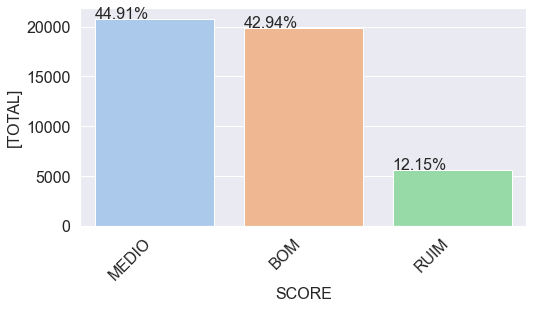

In [12]:
fig = plt.figure(figsize=(8, 4))
ax = sns.countplot(x=fatur['SCORE'], order=['MEDIO', 'BOM', 'RUIM'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/len(fatur)*100), (p.get_x(), p.get_height()+1))
    
plt.xlabel('SCORE')
plt.ylabel('[TOTAL]')
plt.show()

In [13]:
fatur.PERC_ARREC = fatur.PERC_ARREC.str.replace('%', '', regex=False).astype(float)
fatur.PERC_ARREC_EFETIVA = fatur.PERC_ARREC_EFETIVA.str.replace('%', '', regex=False).astype(float)
fatur.PERC_SALDO_EM_ABERTO = fatur.PERC_SALDO_EM_ABERTO.str.replace('%', '', regex=False).astype(float)

In [14]:
def convertToFloat(v):
    v = str(v)
    v= v.replace('R$ ', '') \
                .replace('.', '') \
                .replace(',', '') \
                .replace('\.', '')
    return float(v) / 100.
    
fatur.FATURADO_BRUTO = fatur.FATURADO_BRUTO.apply(convertToFloat)
fatur.ARRECADACAO = fatur.ARRECADACAO.apply(convertToFloat)
fatur.CONTESTACAO = fatur.CONTESTACAO.apply(convertToFloat)
fatur.SALDO_EM_ABERTO = fatur.SALDO_EM_ABERTO.apply(convertToFloat)

In [15]:
fatur['ANOMES_F'] = fatur['ANOMES_F'].fillna(value = '199901')
fatur['COMPETENCIA'] = fatur['ANOMES_F'].apply(lambda x: pd.to_datetime(str(x) + '01'))
fatur.drop(['ANOMES_F'], axis=1, inplace=True)

fatur.head(3)

,RAIZ_CNPJ,CNPJ,FATURADO_BRUTO,ARRECADACAO,PERC_ARREC,CONTESTACAO,PERC_ARREC_EFETIVA,SALDO_EM_ABERTO,PERC_SALDO_EM_ABERTO,INADIMPLENCIA,ARRECADACAO_EFETIVA,AJUSTE,AGING_PGTO,PLANTA,CODIGO_SCORE,SCORE,COMPETENCIA
0,00000000,00000000202101,1030373.12,896918.94,87.0,133454.18,100.0,0.0,0.0,1,1,1,0,1,11011,MEDIO,2021-01-01
1,00000000,00000000202102,959047.87,851549.88,89.0,107497.99,100.0,0.0,0.0,1,1,1,0,-1,110-11,MEDIO,2021-02-01
2,00000000,00000000202103,888815.11,802659.44,90.0,86155.67,100.0,0.0,0.0,1,1,1,0,-1,110-11,MEDIO,2021-03-01


In [16]:
fatur.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46360 entries, 0 to 46359
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   RAIZ_CNPJ             46360 non-null  object        
 1   CNPJ                  46360 non-null  object        
 2   FATURADO_BRUTO        46360 non-null  float64       
 3   ARRECADACAO           38594 non-null  float64       
 4   PERC_ARREC            46360 non-null  float64       
 5   CONTESTACAO           13547 non-null  float64       
 6   PERC_ARREC_EFETIVA    46360 non-null  float64       
 7   SALDO_EM_ABERTO       46360 non-null  float64       
 8   PERC_SALDO_EM_ABERTO  46360 non-null  float64       
 9   INADIMPLENCIA         46360 non-null  object        
 10  ARRECADACAO_EFETIVA   46360 non-null  object        
 11  AJUSTE                46360 non-null  object        
 12  AGING_PGTO            46360 non-null  object        
 13  PLANTA          

In [17]:
fatur['INADIMPLENCIA'] = fatur['INADIMPLENCIA'].astype(int)
fatur['INADIMPLENCIA'].value_counts(dropna=False, ascending=False)

 1    40307
-1     5634
 0      419
Name: INADIMPLENCIA, dtype: int64

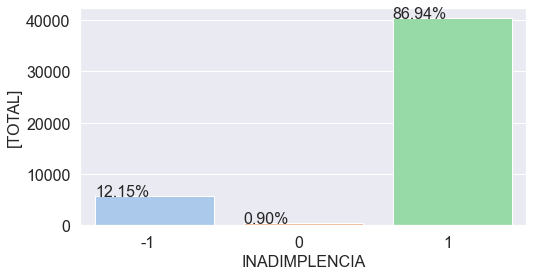

In [18]:
fig = plt.figure(figsize=(8, 4))
ax = sns.countplot(x=fatur['INADIMPLENCIA'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/len(fatur)*100), (p.get_x(), p.get_height()+1))
    
plt.xlabel('INADIMPLENCIA')
plt.ylabel('[TOTAL]')
plt.show()

In [19]:
fatur['ARRECADACAO_EFETIVA'] = fatur['ARRECADACAO_EFETIVA'].astype(int)
fatur['ARRECADACAO_EFETIVA'].value_counts(dropna=False, ascending=False)

 1    40726
-1     4934
 0      700
Name: ARRECADACAO_EFETIVA, dtype: int64

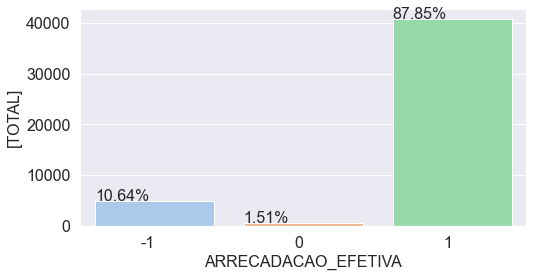

In [20]:
fig = plt.figure(figsize=(8, 4))
ax = sns.countplot(x=fatur['ARRECADACAO_EFETIVA'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/len(fatur)*100), (p.get_x(), p.get_height()+1))
    
plt.xlabel('ARRECADACAO_EFETIVA')
plt.ylabel('[TOTAL]')
plt.show()

In [21]:
fatur['AJUSTE'] = fatur['AJUSTE'].astype(int)
fatur['AJUSTE'].value_counts(dropna=False, ascending=False)

0    32813
1    13547
Name: AJUSTE, dtype: int64

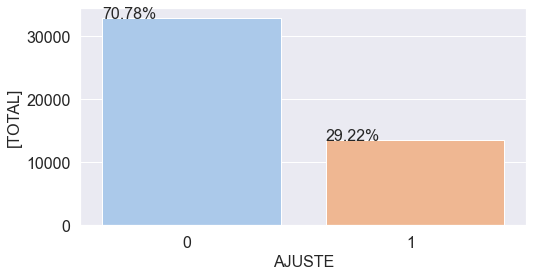

In [22]:
fig = plt.figure(figsize=(8, 4))
ax = sns.countplot(x=fatur['AJUSTE'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/len(fatur)*100), (p.get_x(), p.get_height()+1))
    
plt.xlabel('AJUSTE')
plt.ylabel('[TOTAL]')
plt.show()

In [23]:
fatur['PLANTA'] = fatur['PLANTA'].astype(float)
fatur['PLANTA'].value_counts(dropna=False, ascending=False)

 0.5    24206
 0.0    17667
 1.0     3323
-1.0     1164
Name: PLANTA, dtype: int64

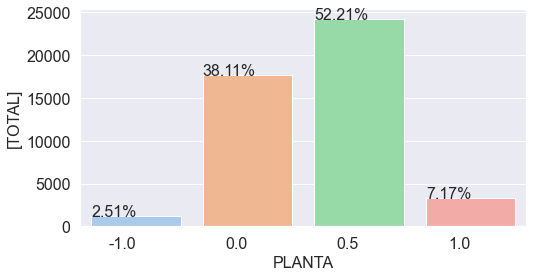

In [24]:
fig = plt.figure(figsize=(8, 4))
ax = sns.countplot(x=fatur['PLANTA'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/len(fatur)*100), (p.get_x(), p.get_height()+1))
    
plt.xlabel('PLANTA')
plt.ylabel('[TOTAL]')
plt.show()

In [25]:
fatur['AGING_PGTO'] = fatur['AGING_PGTO'].apply(lambda x: float(x.replace(',', '.')))
fatur['AGING_PGTO'].value_counts(dropna=False, ascending=False)

 1.0    19910
 0.0    15165
-1.0     7155
 0.5     4130
Name: AGING_PGTO, dtype: int64

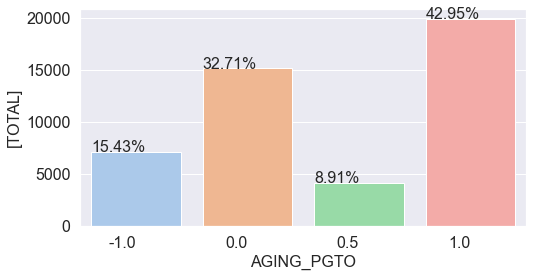

In [26]:
fig = plt.figure(figsize=(8, 4))
ax = sns.countplot(x=fatur['AGING_PGTO'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, horizontalalignment='right')
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(p.get_height()/len(fatur)*100), (p.get_x(), p.get_height()+1))
    
plt.xlabel('AGING_PGTO')
plt.ylabel('[TOTAL]')
plt.show()

In [27]:
fatur.head(3)

,RAIZ_CNPJ,CNPJ,FATURADO_BRUTO,ARRECADACAO,PERC_ARREC,CONTESTACAO,PERC_ARREC_EFETIVA,SALDO_EM_ABERTO,PERC_SALDO_EM_ABERTO,INADIMPLENCIA,ARRECADACAO_EFETIVA,AJUSTE,AGING_PGTO,PLANTA,CODIGO_SCORE,SCORE,COMPETENCIA
0,00000000,00000000202101,1030373.12,896918.94,87.0,133454.18,100.0,0.0,0.0,1,1,1,0.0,1.0,11011,MEDIO,2021-01-01
1,00000000,00000000202102,959047.87,851549.88,89.0,107497.99,100.0,0.0,0.0,1,1,1,0.0,-1.0,110-11,MEDIO,2021-02-01
2,00000000,00000000202103,888815.11,802659.44,90.0,86155.67,100.0,0.0,0.0,1,1,1,0.0,-1.0,110-11,MEDIO,2021-03-01


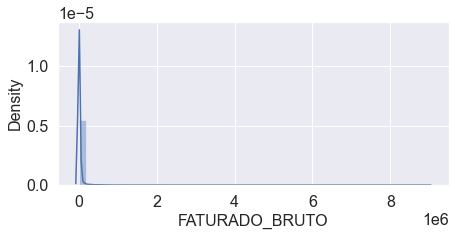

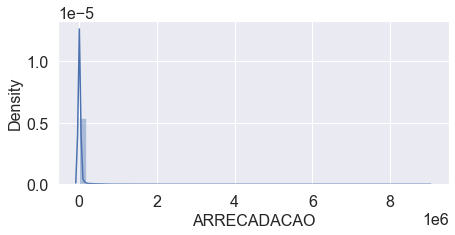

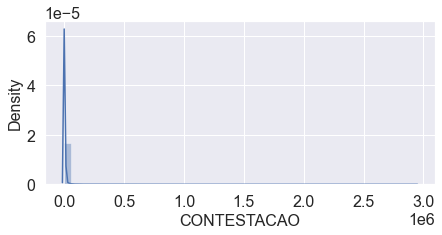

In [29]:
def distplotfeature(temp, column, order=False):
    ##vis
    fig = plt.figure(figsize=(7, 3))
    g = sns.distplot(temp[column], kde=True, color="b")
    ##plot
    plt.show()

for i in ['FATURADO_BRUTO', 'ARRECADACAO', 'CONTESTACAO']:
    distplotfeature(fatur[[i]], i)


In [31]:
fatur.COMPETENCIA = fatur.COMPETENCIA.dt.date

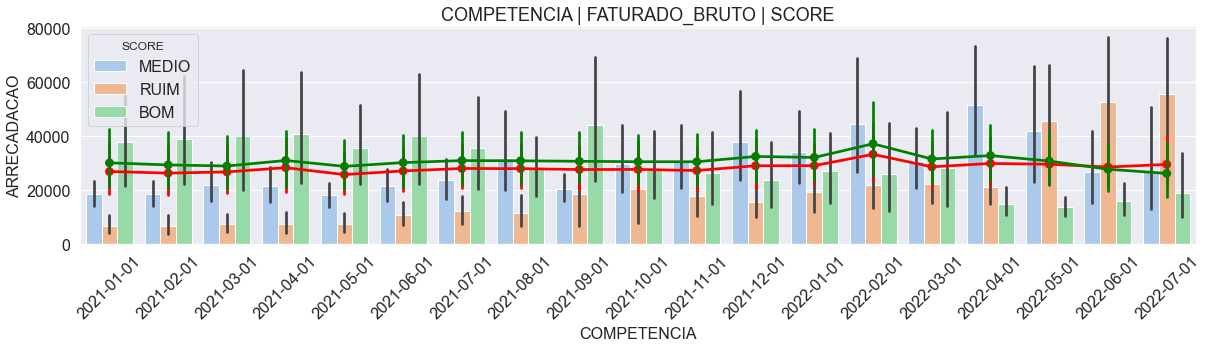

In [32]:
fig, ax = plt.subplots(figsize=(20, 4))

sns.barplot(x="COMPETENCIA", y="FATURADO_BRUTO", data=fatur, ax=ax, hue='SCORE')
sns.pointplot(data=fatur, x='COMPETENCIA', y='FATURADO_BRUTO', color='red')
sns.pointplot(data=fatur, x='COMPETENCIA', y='ARRECADACAO', color='green')

ax.tick_params(axis='x', rotation=45)
plt.title('COMPETENCIA | FATURADO_BRUTO | SCORE')
plt.show()

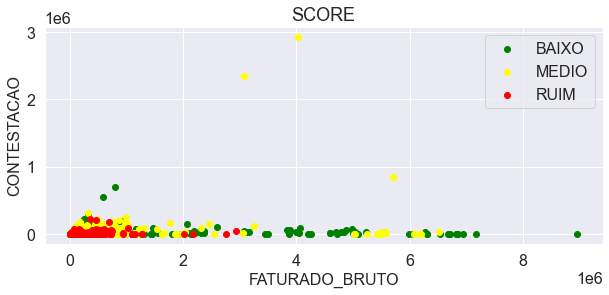

In [33]:
plt.figure(figsize=(10, 4))

columns = ['FATURADO_BRUTO', 'CONTESTACAO', 'SCORE']
colors = ['green', 'yellow', 'red']

plt.scatter(fatur[fatur[columns[2]].str.contains('BOM')==True][columns[0]], 
            fatur[fatur[columns[2]].str.contains('BOM')==True][columns[1]], 
            c = colors[0], label = 'BAIXO')

plt.scatter(fatur[fatur[columns[2]].str.contains('MEDIO')==True][columns[0]], 
            fatur[fatur[columns[2]].str.contains('MEDIO')==True][columns[1]], 
            c = colors[1], label = 'MEDIO')

plt.scatter(fatur[fatur[columns[2]].str.contains('RUIM')==True][columns[0]], 
            fatur[fatur[columns[2]].str.contains('RUIM')==True][columns[1]], 
            c = colors[2], label = 'RUIM')

plt.xlabel(columns[0])
plt.ylabel(columns[1])
plt.title(columns[2])
plt.legend()
plt.show()

#### Modelando a base por fornecedor e competência:

In [34]:
fatur.head(3)

,RAIZ_CNPJ,CNPJ,FATURADO_BRUTO,ARRECADACAO,PERC_ARREC,CONTESTACAO,PERC_ARREC_EFETIVA,SALDO_EM_ABERTO,PERC_SALDO_EM_ABERTO,INADIMPLENCIA,ARRECADACAO_EFETIVA,AJUSTE,AGING_PGTO,PLANTA,CODIGO_SCORE,SCORE,COMPETENCIA
0,00000000,00000000202101,1030373.12,896918.94,87.0,133454.18,100.0,0.0,0.0,1,1,1,0.0,1.0,11011,MEDIO,2021-01-01
1,00000000,00000000202102,959047.87,851549.88,89.0,107497.99,100.0,0.0,0.0,1,1,1,0.0,-1.0,110-11,MEDIO,2021-02-01
2,00000000,00000000202103,888815.11,802659.44,90.0,86155.67,100.0,0.0,0.0,1,1,1,0.0,-1.0,110-11,MEDIO,2021-03-01


In [36]:
fatur['INADIMPLENCIA_{}'.format('BOM')] = fatur['INADIMPLENCIA'].apply(lambda x: 1 if x == 1 else 0)
fatur['INADIMPLENCIA_{}'.format('MEDIO')] = fatur['INADIMPLENCIA'].apply(lambda x: 1 if x == 0 else 0)
fatur['INADIMPLENCIA_{}'.format('RUIM')] = fatur['INADIMPLENCIA'].apply(lambda x: 1 if x == -1 else 0)

fatur.drop('INADIMPLENCIA', axis=1, inplace=True)

In [38]:
fatur['ARRECADACAO_EFETIVA_{}'.format('BOM')] = fatur['ARRECADACAO_EFETIVA'].apply(lambda x: 1 if x == 1 else 0)
fatur['ARRECADACAO_EFETIVA_{}'.format('MEDIO')] = fatur['ARRECADACAO_EFETIVA'].apply(lambda x: 1 if x == 0 else 0)
fatur['ARRECADACAO_EFETIVA_{}'.format('RUIM')] = fatur['ARRECADACAO_EFETIVA'].apply(lambda x: 1 if x == -1 else 0)

fatur.drop('ARRECADACAO_EFETIVA', axis=1, inplace=True)
fatur.head(3)

,RAIZ_CNPJ,CNPJ,FATURADO_BRUTO,ARRECADACAO,PERC_ARREC,CONTESTACAO,PERC_ARREC_EFETIVA,SALDO_EM_ABERTO,PERC_SALDO_EM_ABERTO,AJUSTE,AGING_PGTO,PLANTA,CODIGO_SCORE,SCORE,COMPETENCIA,INADIMPLENCIA_BOM,INADIMPLENCIA_MEDIO,INADIMPLENCIA_RUIM,ARRECADACAO_EFETIVA_BOM,ARRECADACAO_EFETIVA_MEDIO,ARRECADACAO_EFETIVA_RUIM
0,00000000,00000000202101,1030373.12,896918.94,87.0,133454.18,100.0,0.0,0.0,1,0.0,1.0,11011,MEDIO,2021-01-01,1,0,0,1,0,0
1,00000000,00000000202102,959047.87,851549.88,89.0,107497.99,100.0,0.0,0.0,1,0.0,-1.0,110-11,MEDIO,2021-02-01,1,0,0,1,0,0
2,00000000,00000000202103,888815.11,802659.44,90.0,86155.67,100.0,0.0,0.0,1,0.0,-1.0,110-11,MEDIO,2021-03-01,1,0,0,1,0,0


In [39]:
fatur['AJUSTE_{}'.format('BOM')] = fatur['AJUSTE'].apply(lambda x: 1 if x == 1 else 0)
fatur['AJUSTE_{}'.format('MEDIO')] = fatur['AJUSTE'].apply(lambda x: 1 if x == 0 else 0)

fatur.drop('AJUSTE', axis=1, inplace=True)

In [42]:
fatur['AGING_PGTO_{}'.format('BOM')] = fatur['AGING_PGTO'].apply(lambda x: 1 if x == 1. else 0)
fatur['AGING_PGTO_{}'.format('MEDIO')] = fatur['AGING_PGTO'].apply(lambda x: 1 if x == 0. else 0)
fatur['AGING_PGTO_{}'.format('RUIM')] = fatur['AGING_PGTO'].apply(lambda x: 1 if x == -1. else 0)
fatur['AGING_PGTO_{}'.format('SEM_ANALISE')] = fatur['AGING_PGTO'].apply(lambda x: x if x == 0.5 else 0)

fatur.drop('AGING_PGTO', axis=1, inplace=True)

In [45]:
fatur['PLANTA_{}'.format('BOM')] = fatur['PLANTA'].apply(lambda x: 1 if x == 1. else 0)
fatur['PLANTA_{}'.format('MEDIO')] = fatur['PLANTA'].apply(lambda x: 1 if x == 0. else 0)
fatur['PLANTA_{}'.format('RUIM')] = fatur['PLANTA'].apply(lambda x: 1 if x == -1. else 0)
fatur['PLANTA_{}'.format('SEM_ANALISE')] = fatur['PLANTA'].apply(lambda x: x if x == 0.5 else 0)

fatur.drop('PLANTA', axis=1, inplace=True)

In [48]:
score = ['RUIM', 'MEDIO', 'BOM']

for i in score:
    fatur['SCORE_{}'.format(i)] = fatur['SCORE'].apply(lambda x: 1 if x.upper() == i else 0)
    
fatur.drop('SCORE', axis=1, inplace=True)

In [49]:
fatur.head()

,RAIZ_CNPJ,CNPJ,FATURADO_BRUTO,ARRECADACAO,PERC_ARREC,CONTESTACAO,PERC_ARREC_EFETIVA,SALDO_EM_ABERTO,PERC_SALDO_EM_ABERTO,CODIGO_SCORE,COMPETENCIA,INADIMPLENCIA_BOM,INADIMPLENCIA_MEDIO,INADIMPLENCIA_RUIM,ARRECADACAO_EFETIVA_BOM,ARRECADACAO_EFETIVA_MEDIO,ARRECADACAO_EFETIVA_RUIM,AJUSTE_BOM,AJUSTE_MEDIO,AGING_PGTO_BOM,AGING_PGTO_MEDIO,AGING_PGTO_RUIM,AGING_PGTO_SEM_ANALISE,PLANTA_BOM,PLANTA_MEDIO,PLANTA_RUIM,PLANTA_SEM_ANALISE,SCORE_RUIM,SCORE_MEDIO,SCORE_BOM
0,00000000,00000000202101,1030373.12,896918.94,87.0,133454.18,100.0,0.0,0.0,11011,2021-01-01,1,0,0,1,0,0,1,0,0,1,0,0.0,1,0,0,0.0,0,1,0
1,00000000,00000000202102,959047.87,851549.88,89.0,107497.99,100.0,0.0,0.0,110-11,2021-02-01,1,0,0,1,0,0,1,0,0,1,0,0.0,0,0,1,0.0,0,1,0
2,00000000,00000000202103,888815.11,802659.44,90.0,86155.67,100.0,0.0,0.0,110-11,2021-03-01,1,0,0,1,0,0,1,0,0,1,0,0.0,0,0,1,0.0,0,1,0
3,00000000,00000000202104,948576.62,826244.80,87.0,122331.82,100.0,0.0,0.0,110-11,2021-04-01,1,0,0,1,0,0,1,0,0,1,0,0.0,0,0,1,0.0,0,1,0
4,00000000,00000000202105,738621.65,666642.89,90.0,71978.76,100.0,0.0,0.0,110-11,2021-05-01,1,0,0,1,0,0,1,0,0,1,0,0.0,0,0,1,0.0,0,1,0


In [52]:
fatur = fatur.drop(['CODIGO_SCORE'], axis=1) \
    .groupby(['RAIZ_CNPJ', 'COMPETENCIA']) \
    .sum() \
    .reset_index(drop=False) \
    .sort_values(by=['RAIZ_CNPJ', 'COMPETENCIA'])

fatur.head(3)

,RAIZ_CNPJ,COMPETENCIA,FATURADO_BRUTO,ARRECADACAO,PERC_ARREC,CONTESTACAO,PERC_ARREC_EFETIVA,SALDO_EM_ABERTO,PERC_SALDO_EM_ABERTO,INADIMPLENCIA_BOM,INADIMPLENCIA_MEDIO,INADIMPLENCIA_RUIM,ARRECADACAO_EFETIVA_BOM,ARRECADACAO_EFETIVA_MEDIO,ARRECADACAO_EFETIVA_RUIM,AJUSTE_BOM,AJUSTE_MEDIO,AGING_PGTO_BOM,AGING_PGTO_MEDIO,AGING_PGTO_RUIM,AGING_PGTO_SEM_ANALISE,PLANTA_BOM,PLANTA_MEDIO,PLANTA_RUIM,PLANTA_SEM_ANALISE,SCORE_RUIM,SCORE_MEDIO,SCORE_BOM
0,00000000,2021-01-01,1030373.12,896918.94,87.0,133454.18,100.0,0.0,0.0,1,0,0,1,0,0,1,0,0,1,0,0.0,1,0,0,0.0,0,1,0
1,00000000,2021-02-01,959047.87,851549.88,89.0,107497.99,100.0,0.0,0.0,1,0,0,1,0,0,1,0,0,1,0,0.0,0,0,1,0.0,0,1,0
2,00000000,2021-03-01,888815.11,802659.44,90.0,86155.67,100.0,0.0,0.0,1,0,0,1,0,0,1,0,0,1,0,0.0,0,0,1,0.0,0,1,0


### SALVAR DADOS:

In [53]:
fatur.to_csv(r'datasets/02_FATURAMENTO.csv', index = False, sep=';', encoding='utf-8', header='true')

In [54]:
del fatur